# Regression Analysi son Housing Data

In this Jupyter Notebook, we will perform a data analysis on the given dataset. Let's start by reading the data.


In [1]:
# read the .csv file named: data.csv
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
# read the data without causing unicodeDecode error
data = pd.read_csv('data.csv', encoding='latin1')

C:\Users\Salih\AppData\Local\Temp\ipykernel_16296\3312154616.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


By analyzing the histograms, we will be able to observe the distribution patterns of each variable in the dataset. This will provide valuable insights into the data and help us make data-driven decisions during our analysis.

Let's proceed with the analysis and visualize the data distributions using histograms.

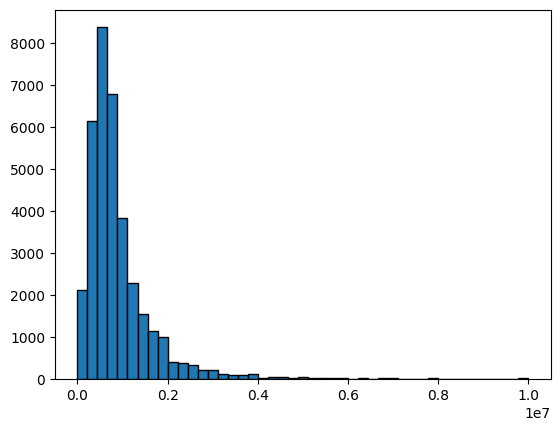

In [2]:
#plot price in histogram
plt.hist(data['Price'],range= (0,10000000), bins=45, edgecolor='black')
plt.show()

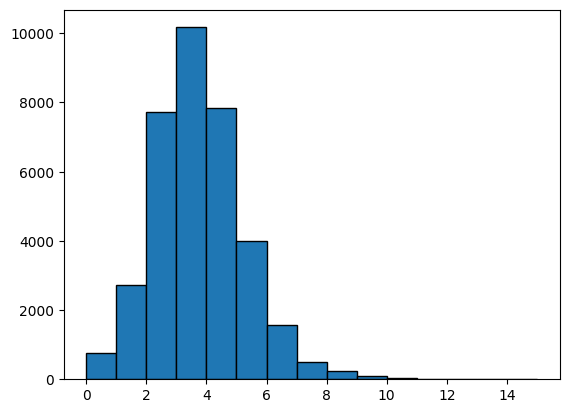

In [3]:
plt.hist(data['Number_Beds'],range= (0,15), bins=15, edgecolor='black')
plt.show()

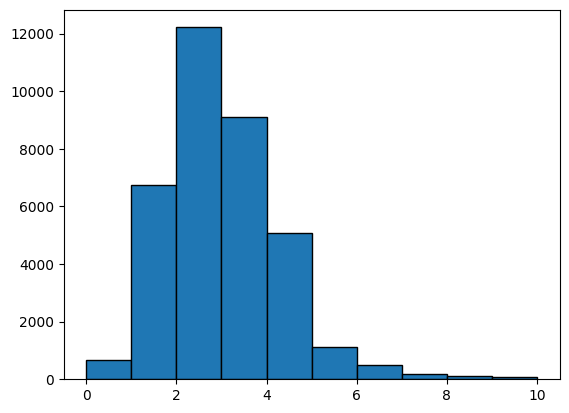

In [4]:
plt.hist(data['Number_Baths'],range= (0,10), bins=10, edgecolor='black')
plt.show()

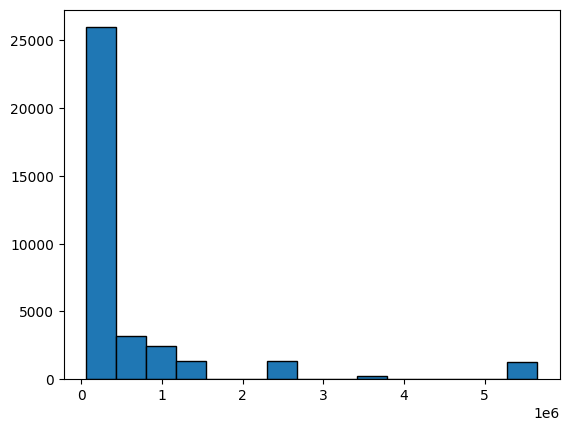

In [5]:
plt.hist(data['Population'], edgecolor='black',bins=15)
plt.show()


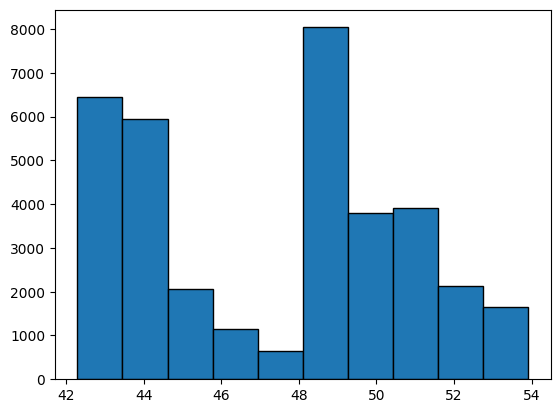

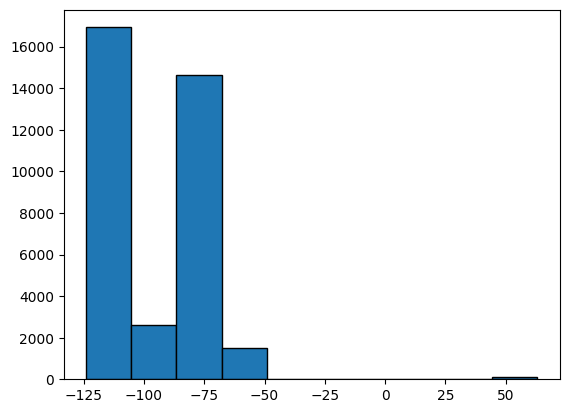

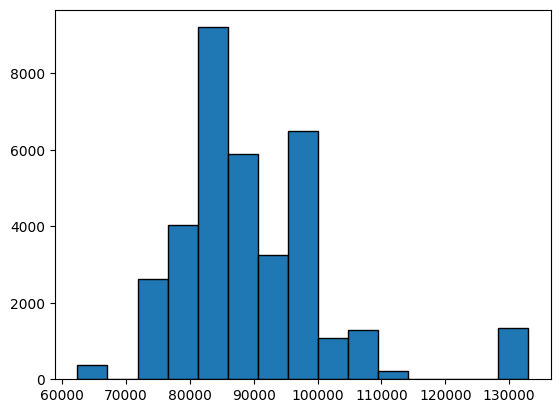

In [6]:
# Latitude,Longitude,Median_Family_Income
plt.hist(data['Latitude'], edgecolor='black')
plt.show()
plt.hist(data['Longitude'], edgecolor='black')
plt.show()
plt.hist(data['Median_Family_Income'], edgecolor='black',bins=15)
plt.show()


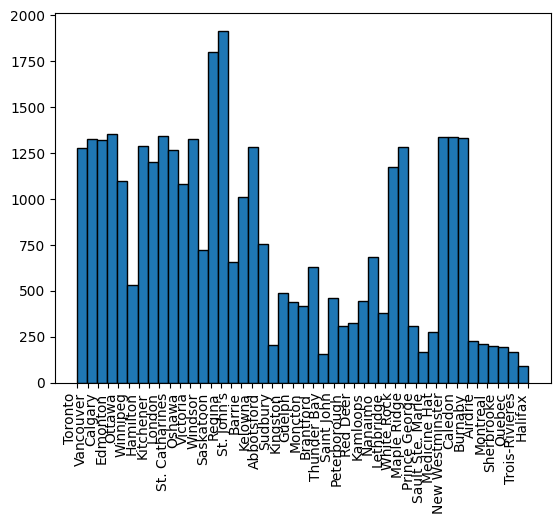

<Figure size 2000x1600 with 0 Axes>

In [7]:

# histogram of cities
plt.hist(data['City'], edgecolor='black',bins=len(data['City'].unique()))

# Rotate x-axis labels diagonally
plt.xticks(rotation='vertical', ha='right')

# Increase the figure size
plt.figure(figsize=(20, 16))  # Adjust the width and height as desired

# Display the plot
plt.show()

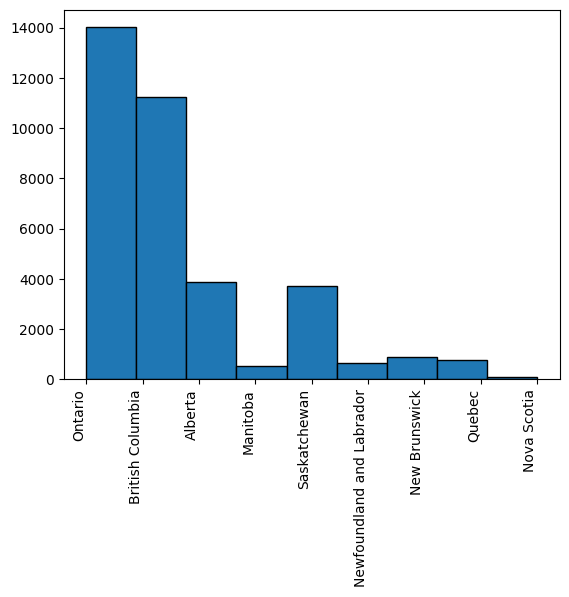

<Figure size 2000x1600 with 0 Axes>

In [8]:

# histogram of cities
plt.hist(data['Province'], edgecolor='black',bins=len(data['Province'].unique()))

# Rotate x-axis labels diagonally
plt.xticks(rotation='vertical', ha='right')

# Increase the figure size
plt.figure(figsize=(20, 16))  # Adjust the width and height as desired

# Display the plot
plt.show()

In [9]:
# explain the data
print(data.describe())

              Price   Number_Beds  Number_Baths    Population      Latitude  \
count  3.576800e+04  35768.000000  35768.000000  3.576800e+04  35768.000000   
mean   9.432963e+05      3.283661      2.532403  6.360151e+05     47.446556   
std    1.020110e+06      1.730654      1.371910  1.120016e+06      3.333855   
min    2.150000e+04      0.000000      0.000000  6.338200e+04     42.283300   
25%    4.599000e+05      2.000000      2.000000  1.091670e+05     43.866700   
50%    6.990000e+05      3.000000      2.000000  2.424600e+05     49.025000   
75%    1.095000e+06      4.000000      3.000000  5.228880e+05     49.888100   
max    3.700000e+07    109.000000     59.000000  5.647656e+06     53.916900   

          Longitude  Median_Family_Income  
count  35768.000000          35768.000000  
mean     -98.421636          89643.103416  
std       22.280935          12132.353510  
min     -123.936400          62400.000000  
25%     -122.316700          82000.000000  
50%     -104.606700     

After analyzing the dataset, it has been observed that the "Address" column contains a large number of unique values, making it unsuitable for any meaningful analysis without the risk of overfitting. Therefore, we will remove the "Address" column from the dataset to ensure accurate and reliable results in our analysis.

In [10]:
data = data.drop(['Address'], axis=1)

We will then delete the outliers for columns that are numerical to increase regression performance. We will delete values that are 3 standard deviation outside from mean

In [11]:
# delete outliers
for i in data.columns:
    if i == 'City' or i == 'Province' or i == "Address":
        continue
    data = data[(np.abs(data[i]-data[i].mean()) <= (3*data[i].std()))]
print(len(data))

32118


Looks like we deleted about 3000 values that is 10 percent of the whole data not so much. Now we use Z score normalization on numerical columns to normalize the data and make it better suited for regression.

In [12]:
# normalize using z score
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
for i in data.columns:
    if i == 'City' or i == 'Province' or i == "Address":
        continue
    data[i] = scaler.fit_transform(data[i].values.reshape(-1,1))

In [13]:
# find unique City and Province
print(len(data['City'].unique()))
print(len(data['Province'].unique()))

42
8


For the categorial columns City and Province we realize that we have only 8 Provinces but for Cities we have a lot of unique values. So for City we take the average of every unique City and use it as the new City column. For province it would make more sense to use one-hot encoding but I realized sometimes for non-shuffled data models would give bad results. So for this assignment instead of using one-hot encoing we will do the same thing we did with Cities.

In [14]:
# find the average price of the houses in each city
average_price = data.groupby('City')['Price'].mean()
# add the average price to the data
data = data.join(average_price, on='City', rsuffix='_average')
# drop the city column
data = data.drop('City', axis=1)

# find the average price of the houses in each Province
average_price2 = data.groupby('Province')['Price'].mean()
# add the average Province to the data
data = data.join(average_price2, on='Province', rsuffix='_average2')
# drop the city column
data = data.drop('Province', axis=1)

Let's check the correlation matrix to see if there is anything interesting

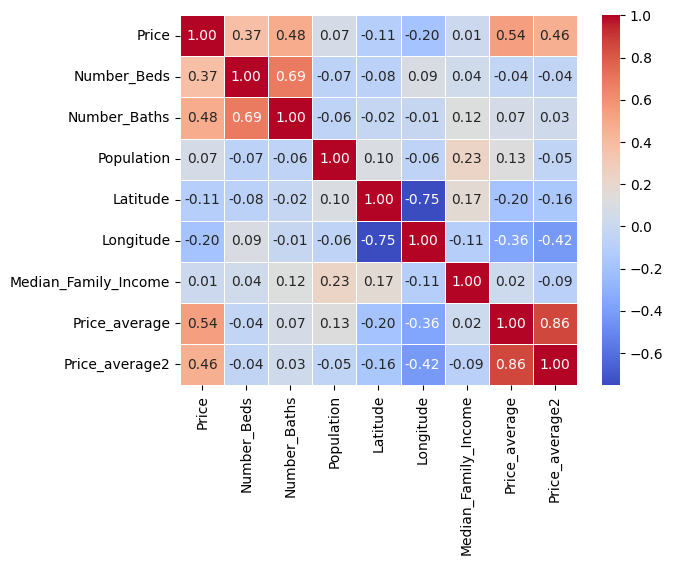

In [15]:

correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.show()

We know import all the necessary functions to evaulate models and we also create a function named modelRunner to run models easily

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
# model runner
def modelRunner(model,train,test,showPlot=True):
    features = train.drop(['Price'], axis=1).columns
    # train the model
    model.fit(train[features], train['Price'])
    # make predictions
    predictions = model.predict(test[features])
    # calculate mean squared error
    mse = mean_squared_error(test['Price'], predictions)
    # calculate r2 score
    r2 = r2_score(test['Price'], predictions)
    #calculate the mean absolute error
    mae = np.mean(np.abs(predictions - test['Price']))
    if showPlot:
        print('Mean Squared Error:', mse)
        print('Mean Absolute Error:', mae)
        print('R2:', r2)
        # plot predictions vs actual
        plt.scatter(test['Price'], predictions)
        plt.xlabel('Actual Labels')
        plt.ylabel('Predicted Labels')
        plt.title('Predictions vs Actuals')
        plt.show()
    return model,r2

# Multiple lineer Regression 

Mean Squared Error: 0.4511303457177818
Mean Absolute Error: 0.40812271477692647
R2: 0.548792643416372


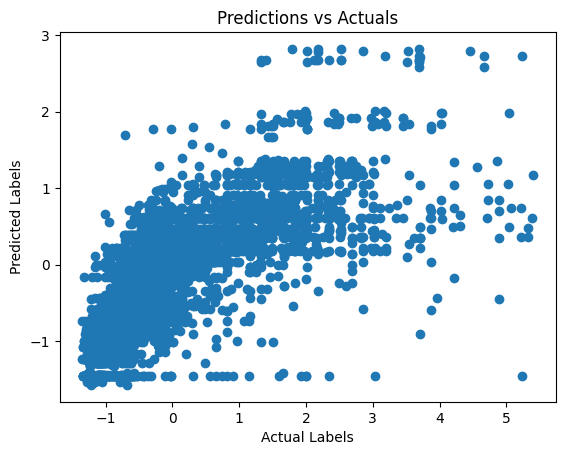

(LinearRegression(), 0.548792643416372)

In [21]:
# test-train split
#add quadratic features
data["Number_Baths2"] = data["Number_Baths"]**2
data["Number_Beds2"] = data["Number_Beds"]**2
data["Population2"] = data["Population"]**2
data["Median_Family_Income2"] = data["Median_Family_Income"]**2
data["Latitude2"] = data["Latitude"]**2
data["Longitude2"] = data["Longitude"]**2
train, test = train_test_split(data, test_size=0.2,shuffle=False)

# create a linear regression model using non-mixed data
model = LinearRegression()
modelRunner(model,train,test)

We got 0.52 as R2 from multiple linear regression without shuffling let's shuffle the data and see if it makes any difference.

Mean Squared Error: 0.46270094041052556
Mean Absolute Error: 0.433722438468424
R2: 0.5280635229294282


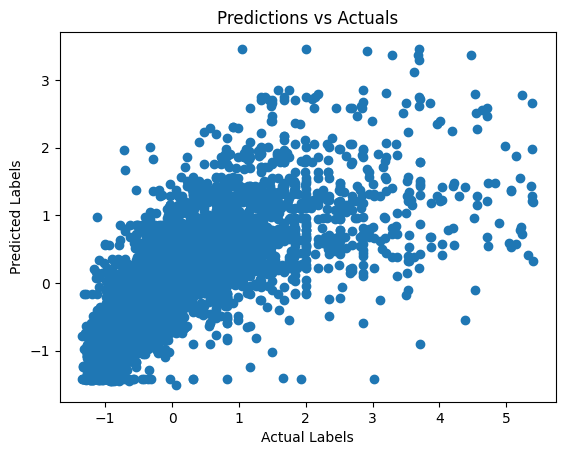

(LinearRegression(), 0.5280635229294282)

In [22]:
# test-train split
train, test = train_test_split(data, test_size=0.2,shuffle=True)

# create a linear regression model using non-mixed data
model = LinearRegression()
modelRunner(model,train,test)

Looks like shuffling did increase the R2 little bit.
# KNN Regression Model

Mean Squared Error: 0.5276073229238045
Mean Absolute Error: 0.44070277644656825
R2: 0.47230261109603955


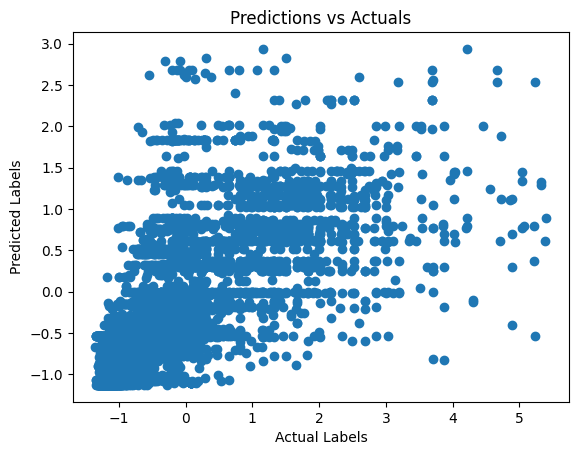

Mean Squared Error: 0.38580273058079173
Mean Absolute Error: 0.385706057229739
R2: 0.601661065138667


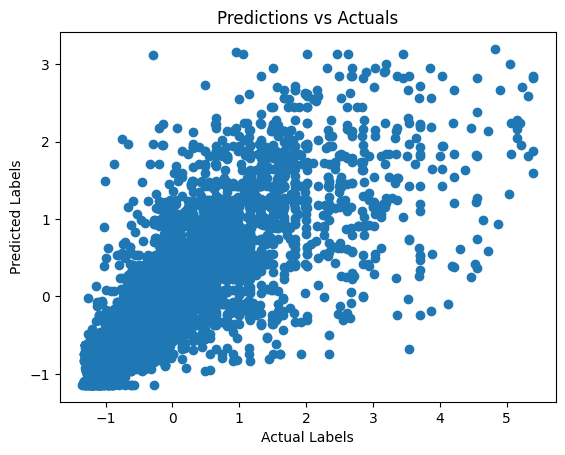

(KNeighborsRegressor(n_neighbors=35), 0.601661065138667)

In [23]:
# train kNN regression model
from sklearn.neighbors import KNeighborsRegressor

# train a kNN regression model
train, test = train_test_split(data, test_size=0.2,shuffle=False)

model = KNeighborsRegressor(n_neighbors=35)
modelRunner(model,train,test)

# test shuffling the data
train, test = train_test_split(data, test_size=0.2)

model = KNeighborsRegressor(n_neighbors=35)
modelRunner(model,train,test)


We see a huge difference between shuffled and non-shuffled data when using KNN regression model. non-shuffled nodel's chart looks very messy.
# Random Forest Regression

Fitting 3 folds for each of 15 candidates, totalling 45 fits
{'max_depth': 10, 'n_estimators': 200}
Mean Squared Error: 0.41443276053386663
Mean Absolute Error: 0.3939483609327544
R2: 0.5927186803971884


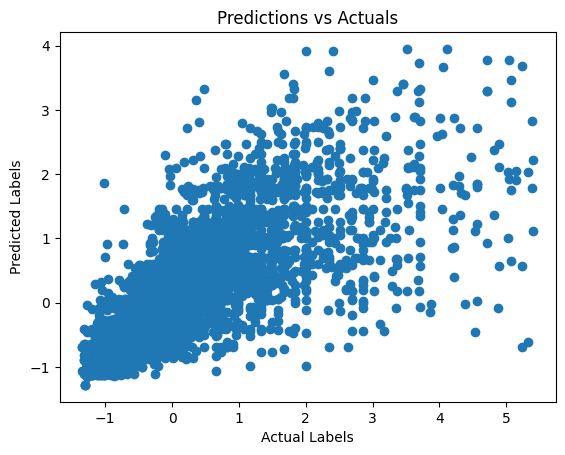

(RandomForestRegressor(max_depth=10, n_estimators=200), 0.5927186803971884)

In [24]:
# train a random forest regression model
from sklearn.ensemble import RandomForestRegressor
train, test = train_test_split(data, test_size=0.2)

# tune hyperparameters by using grid search
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, 40, 50]
}
model = RandomForestRegressor()
features = train.drop(['Price'], axis=1).columns
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(train[features], train['Price'])
print(grid_search.best_params_)
model = grid_search.best_estimator_
modelRunner(model,train,test)

Using random forest regression with grid search we finally exceeded 0.6 R2 mark :). 

# Support Vector Regression

Training support vector regression using rbf kernel.

Mean Squared Error: 0.49383329060174674
Mean Absolute Error: 0.43135415350017425
R2: 0.5060824088637095


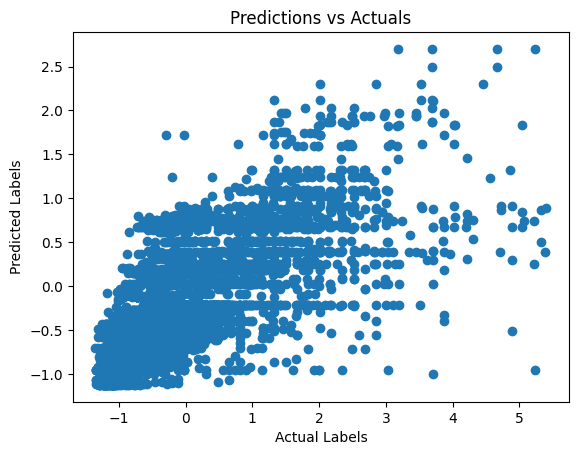

(SVR(), 0.5060824088637095)

In [ ]:
# train a support vector regression model
from sklearn.svm import SVR     
train, test = train_test_split(data, test_size=0.2,shuffle=False)
model = SVR(kernel='rbf')
modelRunner(model,train,test)

# Neural Network Regression using sci-kit library

Mean Squared Error: 0.39841582349679705
Mean Absolute Error: 0.39018586075479345
R2: 0.59958212507137


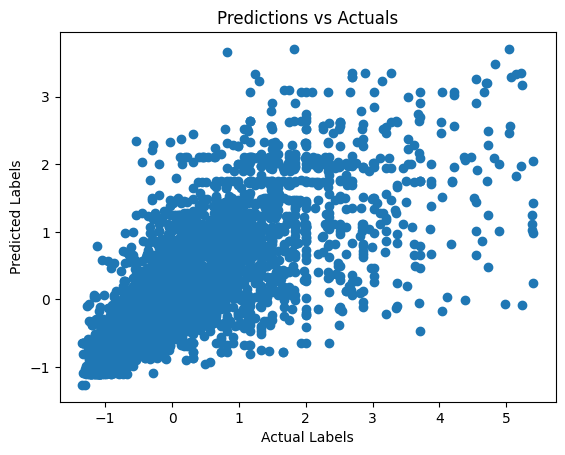

(MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=1000), 0.59958212507137)

In [ ]:
# train a neural network regression model
from sklearn.neural_network import MLPRegressor
train, test = train_test_split(data, test_size=0.2,shuffle=False)
model = MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=1000)
modelRunner(model,train,test)

***Last summer I wanted to learn more about multi-layer perceptrons so using a tutorial I created my own neural network using NO OTHER LIBRARY but python. I want see if my model is good so I will TRAIN a model using my own MLP implementation. You can find the code that I wrote last summer in this repository: https://github.com/SalihErenYzb/MicroGrad***
# MY OWN NEURAL NETWORK

In [ ]:
# neural network out of stracth
import math
class Value( ):
    def __init__(self, data,_creator=tuple(),label=""):
        self._op = " "
        self.label = label
        self.data = data
        self.grad = 0.0
        self._creator = set(_creator)
        self._backward = lambda: None
    def __pow__(self,other):
        other = other if not isinstance(other,Value) else other.data
        out  = Value(self.data**other,_creator=(self,))
        def tmpbackward():
            self.grad += out.grad*other*(self.data**(other-1))
        out._backward = tmpbackward
        return out
    def __add__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data+other.data,_creator= (self,other))
        def tmpbackward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = tmpbackward
        return out
    def __radd__(self,other):
        return self+other
    def __rsub__(self,other):
        return self+other
    def __sub__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data-other.data,_creator= (self,other))
        def tmpbackward():
            self.grad += out.grad
            other.grad -= out.grad
        out._backward = tmpbackward
        return out        
    def tanh(self):
        x = self.data
        out = Value((math.exp(2*x)-1)/(math.exp(2*x)+1),_creator=(self,))
        def tmpbackward():
            self.grad += (1-out.data**2)*out.grad
        out._backward = tmpbackward
        return out
    def __mul__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data*other.data,_creator=(self,other))
        def tmpbackward():
            self.grad += other.data*out.grad
            other.grad += self.data*out.grad
        out._backward = tmpbackward        
        return out
    def backward(self):
        self.grad = 1.0
        visited = set()
        tosort = []
        def toposort(x):
            if x not in visited:
                visited.add(x)
                for el in x._creator:
                    toposort(el)
                tosort.append(x)
        toposort(self)
        for i in reversed(tosort):
            i._backward()
    def __repr__(self):
        return f" Value,data:{self.data}"
from random import uniform

class Neuron:
    def __init__(self,inpsize):
        self.w = [Value(uniform(-0.1,0.1)) for _ in range(inpsize)]
        self.b =Value( uniform(-0.1,0.1))
    def __call__(self,inp):
        return sum((w1*z1 for w1,z1 in zip(self.w,inp)),self.b).tanh()
    def _parameters(self):
        return self.w +[self.b]
class Layer:
    def __init__(self,inpsize,outsize):
        self.neurons = [Neuron(inpsize) for _ in range(outsize)]
    def __call__(self,inp):
        return [self.neurons[i](inp) for i in range(len(self.neurons))]
    def _parameters(self):
        return [param for neuron in self.neurons for param in neuron._parameters()]
class MLP:
    def __init__(self,inpsize,layersizes):
        sizes = [inpsize]+layersizes
        self.layers = [Layer(sizes[i],sizes[i+1]) for i in range(len(layersizes))]
    def __call__(self,inp):
        for i in self.layers:
            inp =i(inp)
        return  inp[0] if len(inp)==1 else inp
    def parameters(self):
        return [param for layer in self.layers for param in layer._parameters()]

***We will delete City average and Province average columns for now because model runs very slow since it is non-optimized and uses just python. Also I will run this model for only first 100 rows because it takes so long for the model to run.***

In [ ]:
data = data.drop(['Price_average','Price_average2'], axis=1)

In [ ]:
mlp = MLP(6,[50,30,1])
#turn data to python array
data = data[:100]
train, test = train_test_split(data, test_size=0.2,random_state=55)
xs = train.to_numpy()
ys = train['Price'].to_numpy()
for id in range(30):
    #forward
    outs = [mlp(x) for x in xs]
    loss = sum([(out-g)**2 for out,g in zip(outs,ys)])
    print(loss)
    #zerograd
    for r in mlp.parameters():
        r.grad = 0.0    

    #backward propagation
    loss.backward()
    #update
    lr = 0.001
    for r in mlp.parameters():
        r.data -= lr*r.grad
    

 Value,data:355.90251269427847
 Value,data:260.44372548292193
 Value,data:223.32889903022408
 Value,data:214.35185803969844
 Value,data:210.38111917622402
 Value,data:207.35012330510472
 Value,data:204.254577233151
 Value,data:200.7050400575483
 Value,data:196.64819967419763
 Value,data:192.46130055191844
 Value,data:188.83078094582206
 Value,data:186.14732211952148
 Value,data:184.27825823984347
 Value,data:182.96528318492497
 Value,data:182.02323823125823
 Value,data:181.33170243758826
 Value,data:180.81207992289978
 Value,data:180.41267204846304
 Value,data:180.09897769129483
 Value,data:179.84754585699693
 Value,data:179.6421266909034
 Value,data:179.47124908838185
 Value,data:179.3266743842381
 Value,data:179.2023915306771
 Value,data:179.0939517750773
 Value,data:178.99801993874527
 Value,data:178.91206643827857
 Value,data:178.83415242314115
 Value,data:178.7627775920001
 Value,data:178.69677089081742


Let's test the model and if it's any good!

Mean Squared Error: 0.3374228046211473
Mean Absolute Error: 0.4171863434891745
R2: 0.6388256118148193


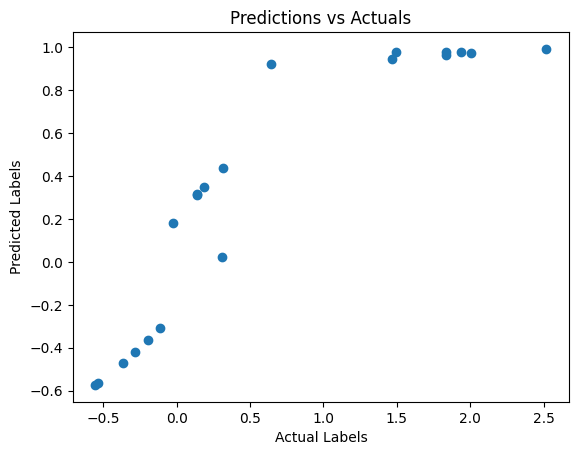

In [ ]:
# predict
xs = test.to_numpy()
ys = test['Price'].to_numpy()
outs = [mlp(x) for x in xs]
# calculate mean squared error
mse = mean_squared_error(ys, [x.data for x in outs])
# calculate r2 score
r2 = r2_score(ys, [x.data for x in outs])
#calculate the mean absolute error
mae = np.mean(np.abs([x.data for x in outs] - ys))
print('Mean Squared Error:', mse)
print('Mean Absolute Error:', mae)
print('R2:', r2)
# plot predictions vs actual
plt.scatter(ys, [x.data for x in outs])
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Predictions vs Actuals')
plt.show()


Our model got 0.63 as R2!! That is very good even though there is only 100 values.
# Gradient Regression Model

We use HistGradientBoostingClassifier because it is much faster for big datasets containing more than 10K samples

Mean Squared Error: 0.4307914376882693
Mean Absolute Error: 0.4048957057099094
R2: 0.5778757257465656


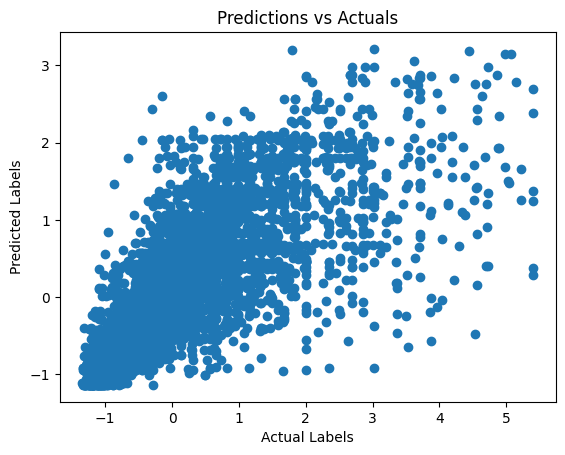

(KNeighborsRegressor(n_neighbors=35), 0.5778757257465656)

In [ ]:
# train a gradient regression model
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn import preprocessing
lab_enc = preprocessing.LabelEncoder()
for i in data.columns:
    data[i] = lab_enc.fit_transform(data[i])
train, test = train_test_split(data, test_size=0.2,shuffle=True)
model = HistGradientBoostingClassifier()
modelRunner(model,train,test)